

## Customer Segmentation (RFM & k-Means Clustering)


**Importing Packages**

In [46]:
# Import Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

**Importing Data**

In [47]:
# Import Retail data containing transaction from 01/12/2010 to 09/12/2011

cust_data = pd.read_csv('CustomerData.csv', encoding='unicode_escape')  
cust_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Exploring & Cleaning Data**

In [48]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Validating records using shape function

In [49]:
# Number of rows and columns in the dataset
cust_data.shape

(541909, 8)

In this dataset as you can see there is a country column which has repeated values for the UK. We observe that country column has similar values for one particular country, so this column is a good candidate to group the customers based on, in order to see the corresponding distribution for different countries.   

In [50]:
# Customer Distribution by Country

country_cust_data = cust_data[['Country','CustomerID']].drop_duplicates() # dropping duplicates
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False) # counting customers for each country

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


As we can see the majority of the customers are from the UK, so we keep the data from the UK only and we filter out the rest of data from other countries.  

In [51]:
# Keeping only UK data
cust_data = cust_data.query("Country == 'United Kingdom'").reset_index(drop=True)

In [52]:
# Checking for missing values in the dataset
cust_data.isnull().sum(axis=0) # axis=0; Checking the columns

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

There are some missing values in Description and CustomerID columns. For now we can ignore the missing values of the Description column.

In [53]:
# Removing misssing values from CustomerID column, can ignore missing values in Description column
cust_data = cust_data[pd.notnull(cust_data['CustomerID'])]
cust_data.shape

(361878, 8)

In [54]:
# Checking if there are any negative values in the Quantity column, as quantity can't have negative value
cust_data.Quantity.min()

-80995

In [55]:
# Checking if there are any negative values in UnitPrice column, as UnitPrice can't have negative value
cust_data.UnitPrice.min()

0.0

We need to clean the data and filter out all the negative values of the Quantity column.

In [56]:
# Filtering out records with negative values
cust_data = cust_data[(cust_data['Quantity'] > 0)]
cust_data.shape

(354345, 8)

Converting date values from string to date format to do date operation related to Recency calculation.

In [57]:
# Converting the string date field to datetime format
cust_data['InvoiceDate'] = pd.to_datetime(cust_data['InvoiceDate'])
#cust_data['InvoiceDate']

Calculating total amount related to Monetary calculation.

In [58]:
# adding new TotalAmount column to the dataframe
cust_data['TotalAmount'] = cust_data['Quantity'] * cust_data['UnitPrice']
#cust_data['TotalAmount']

In [59]:
cust_data.shape

(354345, 9)

In [60]:
cust_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


**Customer Segmentation using RFM Modeling**

RFM (Recency, Frequency, Monetary) analysis is a behavior-based approach grouping customers into segments. It groups the customers on the basis of their previous purchase transactions. How recently, how often, and how much did a customer buy.

In [61]:
# Recency: Latest Date (last invoice Data)
# Frequency: Count of invoice Number of transaction(s)
# Monetary: Sum of Total Amount of purchaed by each customer

import datetime as dt

# Setting latest date 2011-12-10 as last date was 2011-12-09
Latest_Date = dt.datetime(2011,12,10) # using this latest date to calculate the number of days from the recent purchases

# Creating RFM Modeling scores for each customer
# Calculating Recancy, Frequency and Monetary 
RFMScores = cust_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

# Converting InvoiceDate into type int to do the mathematical operation in an easy way
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

# Renaming column names to Recency, Frequency anf Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency',
                          'InvoiceNo': 'Frequency',
                          'TotalAmount': 'Monetary'}, inplace=True)
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4596,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


**Visualization**

In [62]:
# Descritive Statistics (Recency)
RFMScores.Recency.describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

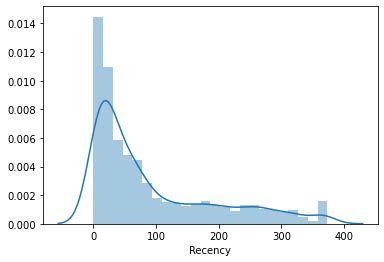

In [63]:
# Recency distribution plot
x = RFMScores['Recency']
ax = sns.distplot(x)

In [64]:
# Descritive Statistics (Frequency)
RFMScores.Frequency.describe()

count    3921.000000
mean       90.371079
std       217.796155
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
max      7847.000000
Name: Frequency, dtype: float64

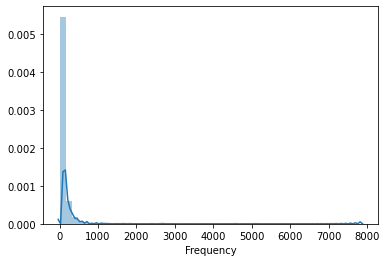

In [65]:
# Frequency distribution plot
x = RFMScores['Frequency']
ax = sns.distplot(x)

In [66]:
# Descritive Statistics (Monetary)
RFMScores.Monetary.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Monetary, dtype: float64

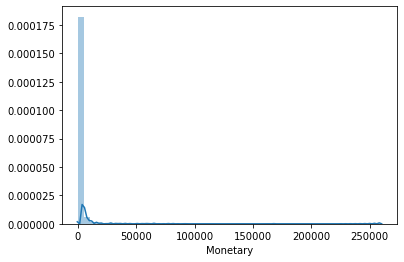

In [67]:
# Monetary distribution plot
x = RFMScores['Monetary']
ax = sns.distplot(x)

As we can see data is right skewed for Recency, Frequency and Monetary. Since in skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model’s performance especially regression-based models, so before they can be used they need to be normalized. 

Creating quantiles (0.25, 0.50, 0.75) to subdivide the entire data set into four group based on Recency, Frequency and Monetary values we are calculated.

In [68]:
# Splitting into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.50,0.75])

# Adding the quantiles into dictionary
quantiles = quantiles.to_dict()  

In [69]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

Defining RScoring() and FMScoring() functions in order to create segments which will be directed by values 1, 2, 3, and 4, with assigning 1 to the lowest value of Recency (lower the value, the better it is - customer is more engaged with a specific brand) and assigning 1 to the highest value of Frequency and Monetary (higher the value, the better it is).

In [70]:
# Creating R, F and M segments 
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x<= d[p][0.50]:
        return 2
    elif x<= d[p][0.75]:
        return 3
    else:
        return 4
    
def FMScoring(x,p,d):
    if x<= d[p][0.25]:
        return 4
    elif x<= d[p][0.50]:
        return 3
    elif x<= d[p][0.75]:
        return 2
    else:
        return 1

In [71]:
# Adding R, F, and M segment value columns in the dataset to show R, F and M segment values.
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency', quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FMScoring, args=('Frequency', quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FMScoring, args=('Monetary', quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


Creating RFMGroup string columns for each customer by using R, F and M values from the dataset to easily check what particular segment or group a customer belongs to.

Adding another new column called RFMScore by summing up the values of R, F, and M values which gives the score to a customer's loyalty or engagement. The lower this RFM score is the more loyal customers would be, as well as more engaged s/he would be with the brand. 

In [72]:
# Adding RFMGroup value column to the dataframe showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str)+RFMScores.F.map(str)+RFMScores.M.map(str)

# Adding RFMScore value column to the dataframe showin total sum of RFMGrop values.
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis=1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,2,103,4196.01,1,1,1,111,3
12748.0,0,4596,33719.73,1,1,1,111,3
12749.0,3,199,4090.88,1,1,1,111,3
12820.0,3,59,942.34,1,2,2,122,5


Assigning loyalty levels to each customer based on RFMScore. To do so, first, we create four levels (Platinum, Gold, Silver and Bronze) and find out each customer belongs to which of these groups. If the customer is in the Platinum group s/he is the most valuable and loyal customer. If the customer belongs to the Bronze group s/he hasn't purchased from quite long and may be on the verge of churning out.

Next we are calculating the score cuts based on panda's qcut() method. 

The simplest use of qcut is to define the number of quantiles and let pandas figure out how to divide up the data. In the below, we tell pandas to create 4 equal sized groupings of the data.

One of the challenges with this approach is that the bin labels are not very easy to explain to an end user. For instance, if we wanted to divide our customers into 4 groups we can explicitly label the bins to make them easier to interpret.

In [73]:
# Assigning loyalty level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_Cuts = pd.qcut(RFMScores.RFMScore, q=4, labels=Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_Cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,2,103,4196.01,1,1,1,111,3,Platinum
2,12748.0,0,4596,33719.73,1,1,1,111,3,Platinum
3,12749.0,3,199,4090.88,1,1,1,111,3,Platinum
4,12820.0,3,59,942.34,1,2,2,122,5,Platinum


The above result explicitly defined the range of quantiles and defined the labels (labels=Loyalty_Level) to use when representing the bins. As expected, we now have an equal distribution of customers across the 4 bins and the results are displayed in an easy to understand manner.
So, this is the way we can assign the loyalty levels to each customer.

In [74]:
# Validating the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup'] == '111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,0,431,259657.30,1,1,1,111,3,Platinum
1,17450.0,8,337,194550.79,1,1,1,111,3,Platinum
2,17511.0,2,963,91062.38,1,1,1,111,3,Platinum
3,16684.0,4,277,66653.56,1,1,1,111,3,Platinum
4,14096.0,4,5111,65164.79,1,1,1,111,3,Platinum
5,13694.0,3,568,65039.62,1,1,1,111,3,Platinum
6,15311.0,0,2379,60767.90,1,1,1,111,3,Platinum
7,13089.0,2,1818,58825.83,1,1,1,111,3,Platinum
8,15769.0,7,130,56252.72,1,1,1,111,3,Platinum
9,15061.0,3,403,54534.14,1,1,1,111,3,Platinum


Customers with RFMGroup 111 have loyalty levels as Platinum. So, first, the data was filtered on the basis of the RFM group equals to 111 which is the best group, then sorted in descending order based on Monetary value. You can see customers with the highest Monetary value in Platinum group have been shown at the top. Based on this RFM modeling what should be the marketing strategy? Customers with the RFM group of 111 are the best customers and we can try to cross sell other products of our brand and also encourage them to sign up for loyalty programs to get some elite benefits like free same-day shipping priority access to newly launched products, etc. On the other hand, for customers with RFM group 444 companies may try to offer some rewards or coupons to trigger their spending.  

**Visualizing RFM modeling based on clusters**

In [75]:
## Importing Libraries

import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

In [76]:
## We can see all observations on the graph
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

In [77]:
## Plotting Recency vs Frequency
plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers', # each data point is represented as marker point
        name='Bronze',
        marker= dict(size=10, line=dict(width=1), color='blue', opacity=0.8)),
    
     gobj.Scatter(
         x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
         y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
         mode='markers',
         name='Silver',
         marker= dict(size=9, line=dict(width=1), color='yellow', opacity=0.5)),
    
     gobj.Scatter(
         x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
         y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
         mode='markers',
         name='Gold',
         marker= dict(size=8, line=dict(width=1), color='green', opacity=0.9)),
    
     gobj.Scatter(
         x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
         y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
         mode='markers',
         name='Platinum',
         marker= dict(size=7, line=dict(width=1), color='red', opacity=0.9)),]

plot_layout = gobj.Layout(
             yaxis={'title': "Frequency"},
             xaxis={'title': "Recency"},
             title='Segments',
             autosize=False,
             width=600,
             height=400)
fig = gobj.Figure(data=plot_data, layout=plot_layout)
#po.plot(fig)
fig.show()

In [78]:
# Plotting Recency vs Monetary

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size=10, line=dict(width=1), color='blue', opacity=0.8)),
    
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size=9, line=dict(width=1), color='yellow', opacity=0.5)),
    
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size=8, line=dict(width=1), color='green', opacity=0.9)),
    
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size=7, line=dict(width=1), color='red', opacity=0.9)),]

plot_layout = gobj.Layout(
             yaxis={'title': "Monetary"},
             xaxis={'title': "Recency"},
             title='Segments',
             autosize=False,
             width=600,
             height=400)
fig = gobj.Figure(data=plot_data, layout=plot_layout)
#po.plot(fig)
fig.show()

In [79]:
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

In [80]:
# Plotting Frequency vs Monetary
plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size=10, line=dict(width=1), color='blue', opacity=0.8)),
    
     gobj.Scatter(
         x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
         y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
         mode='markers',
         name='Silver',
         marker= dict(size=9, line=dict(width=1), color='yellow', opacity=0.5)),
    
     gobj.Scatter(
         x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
         y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
         mode='markers',
         name='Gold',
         marker= dict(size=8, line=dict(width=1), color='green', opacity=0.9)),
    
     gobj.Scatter(
         x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
         y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
         mode='markers',
         name='Platinum',
         marker= dict(size=7, line=dict(width=1), color='red', opacity=0.9)),]

plot_layout = gobj.Layout(
             yaxis={'title': "Monetary"},
             xaxis={'title': "Frequency"},
             title='Segments',
             autosize=False,
             width=600,
             height=400)
fig = gobj.Figure(data=plot_data, layout=plot_layout)
#po.plot(fig)
fig.show()

**k-Means Clustering** 

**Data Prepration**

We are handling the negative and zero values because these values go negative in finite when they are on log scale as we are going to use log transformation for making this data normally distributed. 

In [81]:
# To do normalization, we handle negative and zero values to handle infinite numbers during log transformation 

def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
    
# Apply handle_neg_n_zero function to Recency and Monetary columns
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

# Performing log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis=1).round(3)

We need to normalize and scale the data in order to create the clusters out of the data points, because clustering uses distances as a similarity factor and for the skewed data we normalize the data.

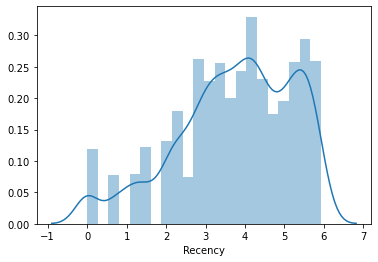

In [82]:
# Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

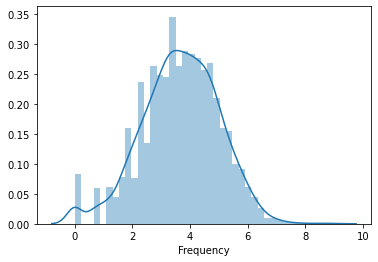

In [83]:
# Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data['Frequency']
ax = sns.distplot(Frequency_Plot)

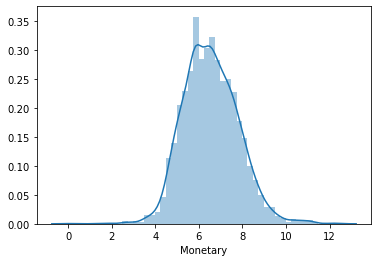

In [84]:
# Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data['Monetary']
ax = sns.distplot(Monetary_Plot)

The graphs show that the data is kind of normally distributed after normalization by applying log transformation.

Now we are trying to get the Recency, Frequency and Monetary on the same scale.

**Standardization**

In [85]:
# Scaling data 
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

# Transform it back to the dataframe
Scaled_data = pd.DataFrame(Scaled_Data, index=RFMScores.index, columns=Log_Tfd_Data.columns)

The Elbow method involves running the algorithm multiple times over a loop with an increasing number of cluster choices and then plotting a clustering score as a function of the number of clusters. When k increases the centroids are closer to cluster centroids.

Below elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-15) and then for each value of k computes an average score for all clusters. 

Utilizing the init parameter, which determines how the initial clusters are placed in step 1 of the algorithm. One of the values we can provide for this parameter is “k-means++”, which is an optimization of the algorithm by choosing initial cluster centers in a smart way to speed up convergence. Also providing a max_iter parameter, which is the maximum number of iterations of the algorithm for each run and we selected as 1000. 

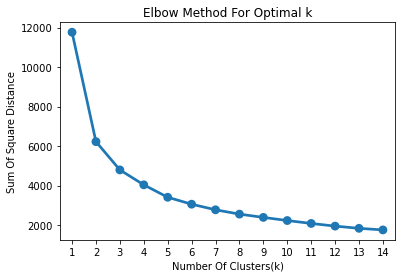

In [86]:
# Defining Sum of square distance dictionary, holding inertia attribute values to identify the sum of squared distances of samples to the nearest cluster center
sum_of_sq_dist = {}  

# We iterate the values of k from 1 to 15 and calculate the inertia for each value of k in the given range.
# init determines the method for initialization
for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    km = km.fit(Scaled_Data)
    
    # Storing inertia attributes values in the dictionary sum_of_sq_dist
    sum_of_sq_dist[k] = km.inertia_
    
# Plotting the graph for the sum of square distance values and number of clusters (range of 1 to 15)
sns.pointplot(x=list(sum_of_sq_dist.keys()), y=list(sum_of_sq_dist.values()))
plt.xlabel('Number Of Clusters(k)')
plt.ylabel('Sum Of Square Distance')
plt.title('Elbow Method For Optimal k')
plt.show()
    

Since our k is the sum of square distance is dramatically decreasing at k=3 of the elbow of this line, we consider 3 as optimal value of k in our case. So, the number of clusters is equal to 3 here.

In [87]:
# Performing k-Mean clustring model
KMean_clust = KMeans(n_clusters = 3, init='k-means++', max_iter=1000)
KMean_clust.fit(Scaled_Data)

# Finding the clusters for the observation given in the dataset
# Adding cluster value for each customer to the Cluster column
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,1
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2


**Results and Discussion** 

In the k-Means method we only have three clusters as against the RFM model where we had four clusters, Platinum, Gold, Silver and Bronze. We can infer that in the case of k-Means out of four clusters two clusters merge together and the remaining two left as it is. So, groups Silver and Bronze seem to be merged into group number two and Platinum and Gold stay in groups 0 and 1.

Now we are plotting the data points in the form of clusterings using matplotlib library.

<Figure size 288x288 with 0 Axes>

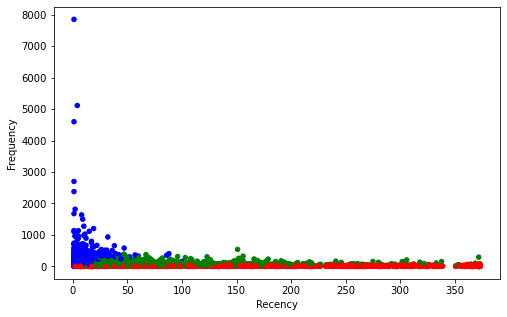

In [88]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4))

# Scatter plot Frequency vs Recency
Colors = ["red", "green", "blue"]

# We will assign a specific color to a specific cluster 
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(kind='scatter', x="Recency", y="Frequency", figsize=(8,5), c=RFMScores['Color'])


In [89]:
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,1,green
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2,blue
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2,blue
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2,blue
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2,blue


**Conclusion and Summary**

As usual in data science, cleaning and feature engineering took 80% of the time, but the resulting clustering was well worth the effort. Customer segmentation can have an incredible impact on a business when done well.

In this assignment we’ve identified four segments (Platinium, Gold, Silver and Bronze) implementing the RFM clustering model. Three segments was implemented by k-Means algorithm, **High (Platinum)** - Group who buys often, spends more and visited the platform recently (high score of RFM), 
**Medium (Gold)** - Group which spends less than high group and is not that much frequent to visit the platform (medium score of RFM), and **Low (Silver)** - Group which is on the verge of churning out (low score of RFM).

Based on this RFM modeling what should be the marketing strategy? Customers with the Platinum RFM loyalty level are the best customers and companies can try to cross sell other products of their brands. Also, they can encourage them to sign up for loyalty programs to get some elite benefits like free same-day shipping priority access to newly launched products, etc. On the other hand, for customers with the Silver RFM loyalty level companies may try to offer some rewards or coupons to trigger their spending. 

It would be fascinating to explore more of the data, and  segment customers further by product line. For example, offering some seasonal products or promotions may receive very different reactions depending on how conservative or adventurous the recipient of the offer.

**References**

- [1] : https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python
- [2] : https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
- [3] : https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945
- [4] : https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945